# Step 1. 데이터셋 내려받기

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [3]:
data_dir

PosixPath('/aiffel/.keras/datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


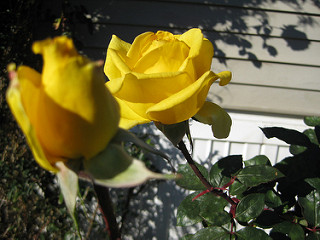

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

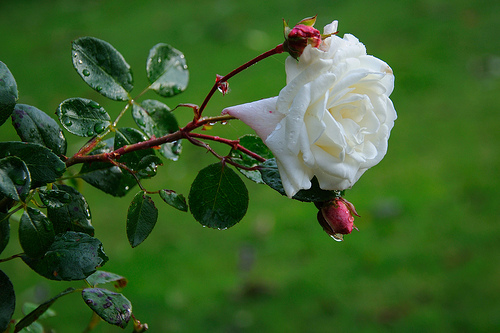

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [8]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name = 'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir=data_dir,
    download=True,
    with_info=True,
    as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /aiffel/.keras/datasets/flower_photos/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [10]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


# Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [11]:
import matplotlib.pyplot as plt

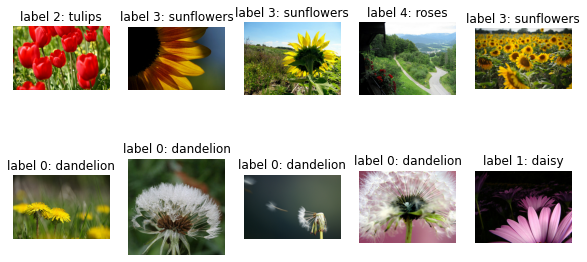

In [16]:
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [35]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [36]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


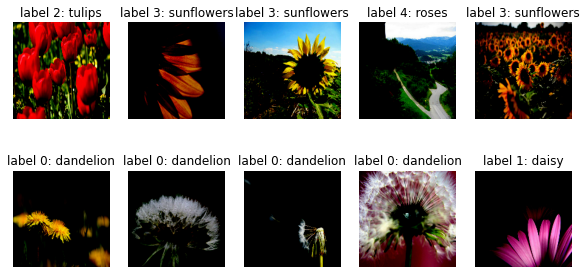

In [37]:
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [38]:
batch_size = 32
shuffle = 1000

In [39]:
train_batches = train.shuffle(shuffle).batch(batch_size)
validation_batches = validation.shuffle(shuffle).batch(batch_size)
test_batches = test.batch(batch_size)

# Step 3. 모델 설계하기

In [51]:
from tensorflow import keras

In [58]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(5, activation='softmax'))

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)      

# Step 4. 모델 학습시키기(직접 설계)

In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics='accuracy')

In [62]:
history = model.fit(train_batches, epochs=15, validation_data=validation_batches)

Epoch 1/15
92/92 [==============================] - 10s 58ms/step - loss: 1.6069 - accuracy: 0.2228 - val_loss: 1.5209 - val_accuracy: 0.5014
Epoch 2/15
92/92 [==============================] - 4s 39ms/step - loss: 1.4698 - accuracy: 0.3566 - val_loss: 1.2528 - val_accuracy: 0.5313
Epoch 3/15
92/92 [==============================] - 4s 38ms/step - loss: 1.3858 - accuracy: 0.4040 - val_loss: 1.2246 - val_accuracy: 0.4714
Epoch 4/15
92/92 [==============================] - 4s 40ms/step - loss: 1.2913 - accuracy: 0.4475 - val_loss: 1.1253 - val_accuracy: 0.5858
Epoch 5/15
92/92 [==============================] - 4s 39ms/step - loss: 1.2529 - accuracy: 0.4642 - val_loss: 1.0854 - val_accuracy: 0.6158
Epoch 6/15
92/92 [==============================] - 4s 38ms/step - loss: 1.2076 - accuracy: 0.4830 - val_loss: 1.0708 - val_accuracy: 0.6240
Epoch 7/15
92/92 [==============================] - 4s 38ms/step - loss: 1.1434 - accuracy: 0.5157 - val_loss: 1.0316 - val_accuracy: 0.6431
Epoch 8/15
9

# Step 5. 모델 성능 평가하기

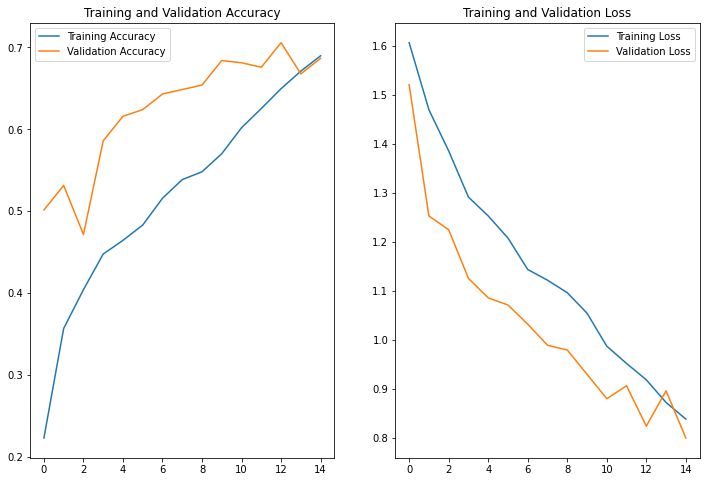

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [71]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

array([[1.51613355e-03, 1.44986175e-02, 5.91924369e-01, 9.52416938e-03,
        3.82536739e-01],
       [7.53701866e-01, 2.16505438e-01, 6.94140699e-03, 5.52880485e-03,
        1.73225030e-02],
       [5.15477359e-01, 6.09713309e-02, 5.63311838e-02, 3.30203474e-01,
        3.70166823e-02],
       [7.83019215e-02, 1.18815958e-01, 2.84754395e-01, 6.79064617e-02,
        4.50221300e-01],
       [8.72952640e-01, 6.23838380e-02, 1.53621277e-02, 2.21855529e-02,
        2.71158814e-02],
       [7.34328806e-01, 1.17686898e-01, 3.61502543e-02, 5.52393273e-02,
        5.65947592e-02],
       [5.58484485e-03, 3.46381553e-02, 6.43128097e-01, 1.79079361e-02,
        2.98740953e-01],
       [1.93346798e-01, 4.90115672e-01, 1.15827136e-01, 6.78545013e-02,
        1.32855892e-01],
       [3.50358747e-02, 9.99714248e-04, 7.56715657e-03, 9.54041004e-01,
        2.35610805e-03],
       [9.37699139e-01, 3.83260809e-02, 5.31670684e-03, 8.42234772e-03,
        1.02356551e-02],
       [8.02402973e-01, 9.2676

In [72]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 4, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 3, 1, 4, 2, 0,
       1, 0, 1, 3, 4, 2, 2, 3, 0, 1])

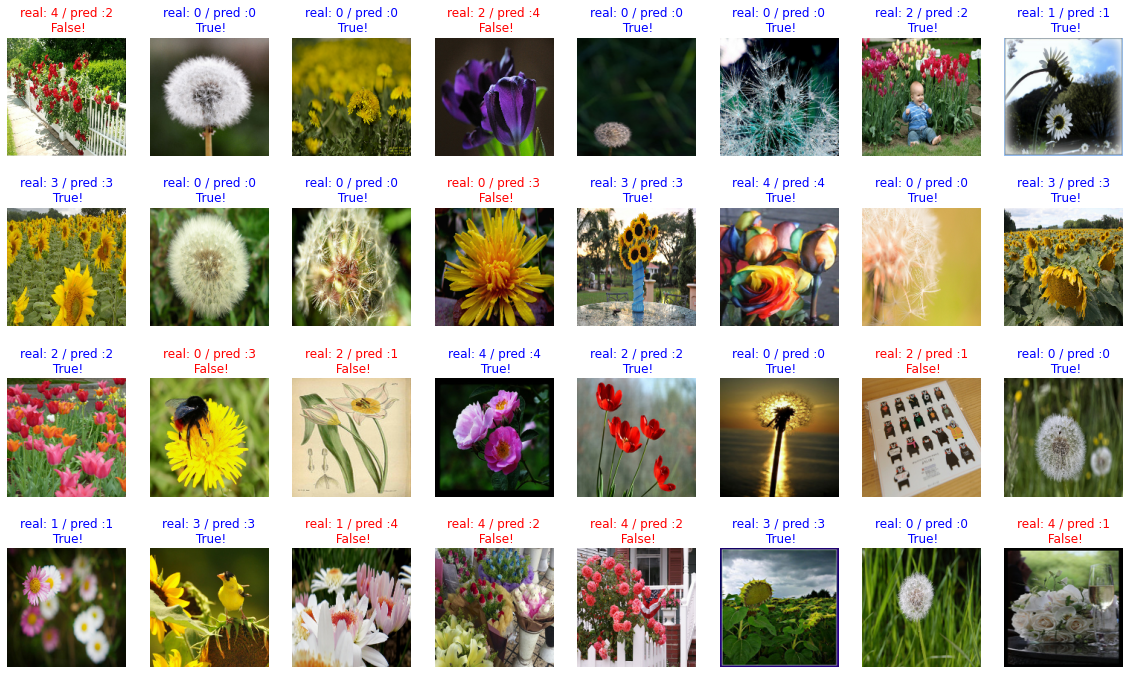

In [73]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [74]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count += 1

print(count / 32 * 100)

68.75


# Step 6. Transper learning(VGG16 사용)

In [86]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [87]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [88]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [89]:
base_model.trainable = False

In [90]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [91]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [92]:
base_learning_rate = 0.0001
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']   
)

In [93]:
EPOCHS = 10   
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)

Epoch 1/10
92/92 [==============================] - 16s 129ms/step - loss: 1.3512 - accuracy: 0.5204 - val_loss: 1.1244 - val_accuracy: 0.6349
Epoch 2/10
92/92 [==============================] - 8s 78ms/step - loss: 1.0266 - accuracy: 0.6935 - val_loss: 0.8964 - val_accuracy: 0.7193
Epoch 3/10
92/92 [==============================] - 8s 79ms/step - loss: 0.8517 - accuracy: 0.7459 - val_loss: 0.7829 - val_accuracy: 0.7439
Epoch 4/10
92/92 [==============================] - 8s 78ms/step - loss: 0.7499 - accuracy: 0.7640 - val_loss: 0.7034 - val_accuracy: 0.7548
Epoch 5/10
92/92 [==============================] - 8s 80ms/step - loss: 0.6842 - accuracy: 0.7854 - val_loss: 0.6610 - val_accuracy: 0.7684
Epoch 6/10
92/92 [==============================] - 8s 80ms/step - loss: 0.6357 - accuracy: 0.7970 - val_loss: 0.6209 - val_accuracy: 0.7847
Epoch 7/10
92/92 [==============================] - 8s 80ms/step - loss: 0.5984 - accuracy: 0.8110 - val_loss: 0.5972 - val_accuracy: 0.7766
Epoch 8/10


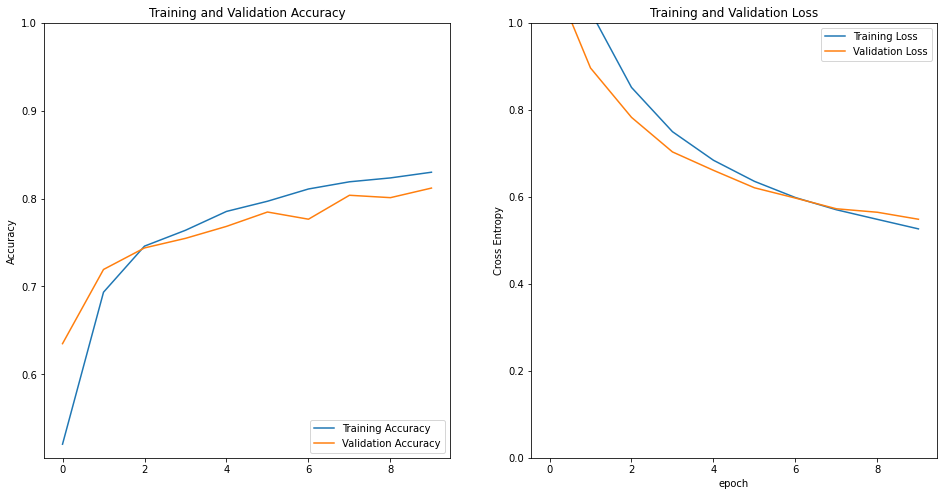

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [95]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.86486447e-02, 6.65034950e-02, 7.39586174e-01, 5.20170853e-02,
        1.13244645e-01],
       [9.98061836e-01, 1.59279665e-03, 3.39041726e-05, 1.73933455e-04,
        1.37577867e-04],
       [7.45166421e-01, 1.24245606e-01, 2.87839826e-02, 8.46309736e-02,
        1.71730127e-02],
       [4.43547126e-03, 1.74365807e-02, 6.15010142e-01, 1.11636166e-02,
        3.51954192e-01],
       [5.94348490e-01, 3.52593333e-01, 1.89512726e-02, 1.39173251e-02,
        2.01895665e-02],
       [8.99681628e-01, 6.72072023e-02, 6.93589263e-03, 2.41426136e-02,
        2.03272118e-03],
       [1.78102981e-02, 1.95922256e-02, 7.41124332e-01, 1.56837866e-01,
        6.46352917e-02],
       [3.90180886e-01, 4.73678142e-01, 2.75949296e-03, 1.28581688e-01,
        4.79977299e-03],
       [1.41115477e-02, 3.09930160e-03, 3.77469249e-02, 8.45259249e-01,
        9.97828841e-02],
       [9.99251544e-01, 6.37350953e-04, 4.66437996e-06, 1.02264472e-04,
        4.15497607e-06],
       [9.64530349e-01, 2.9222

In [96]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

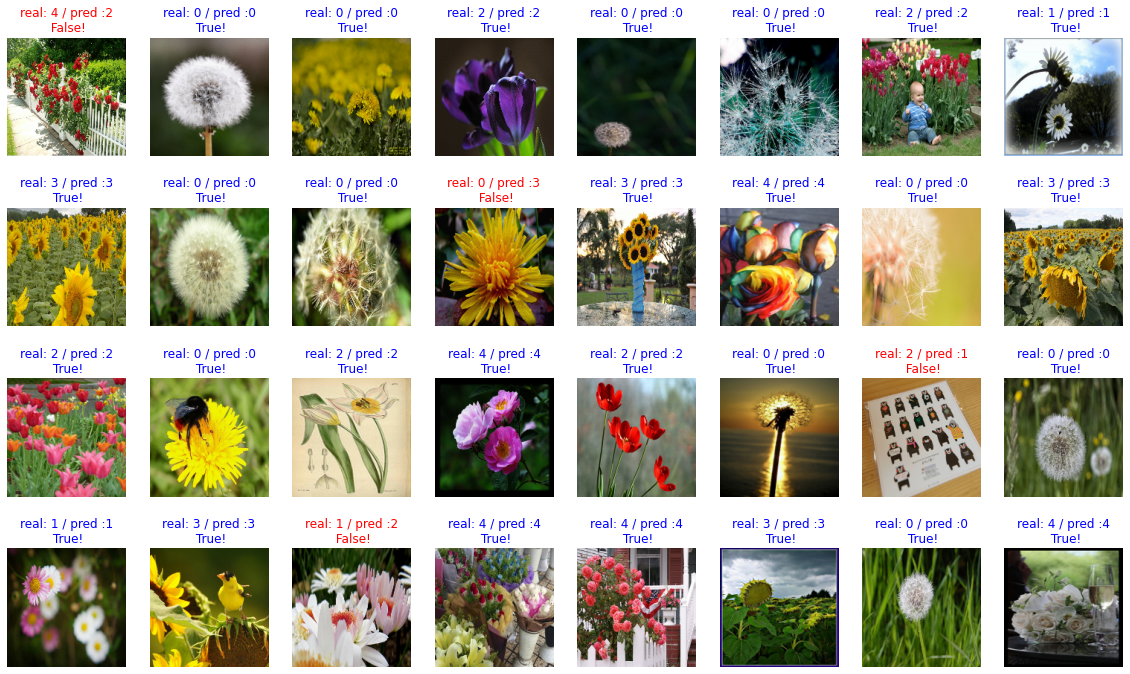

In [97]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [98]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) 

87.5
